In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import re

import geopandas as gpd
import requests,json


from shapely import geos
from shapely.geometry import Point
import fiona
from fiona.crs import from_epsg,from_string

from geopandas import GeoDataFrame
from shapely.geometry import Polygon
from geopandas import GeoSeries


from shapely import geometry
from shapely.geometry import shape,LineString,Point,Polygon

import osmnx as ox
import networkx as nx

import folium

from folium import IFrame

import seaborn as sns
import branca

In [3]:
def rest(address):
    try:
        url = 'https://api.tomtom.com/search/2/geocode/{}.json?&key=h2n93GznJsnsDHtv2vPpdT9GmJijp9o9&countrySet=TWN&language=zh-TW&limit=1'.format(address)
        response = requests.get(url)
        data = response.text
        js = json.loads(str(data))
        return js['results'][0]['position']
    except Exception as e:
        print(f'An Error occurred: {e}')
        return {'lat':0,'lon':0}
    
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:4326'})
    return gdf

def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]

heading3 = """<h3>{}</h3>""".format

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
os.chdir(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data')

# 村里邊界資料整理

In [6]:
gdf=gpd.read_file(r'C:/Users/RT009223/GIS/村里/VILLAGE_MOI_1090423.shp',encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf=trans(gdf)
print(gdf.shape)

(7965, 4)


In [7]:
gdf[gdf['VILLNAME'].isna()]

,COUNTYNAME,TOWNNAME,VILLNAME,geometry
0,屏東縣,東港鎮,None,"POLYGON ((120.48059 22.42686, 120.47641 22.428..."
214,連江縣,莒光鄉,None,"POLYGON ((119.96615 25.97504, 119.96612 25.975..."
215,連江縣,莒光鄉,None,"POLYGON ((119.96638 25.97522, 119.96636 25.975..."
216,連江縣,莒光鄉,None,"POLYGON ((119.96641 25.97532, 119.96641 25.975..."
217,連江縣,莒光鄉,None,"POLYGON ((119.96627 25.97487, 119.96626 25.974..."
...,...,...,...,...
7346,新北市,萬里區,None,"POLYGON ((121.69211 25.20408, 121.69217 25.203..."
7347,新北市,萬里區,None,"POLYGON ((121.68692 25.20635, 121.68702 25.204..."
7366,新北市,金山區,None,"POLYGON ((121.65137 25.22593, 121.65152 25.225..."
7392,新北市,石門區,None,"POLYGON ((121.50943 25.28444, 121.50950 25.284..."


In [8]:
gdf=gdf.dropna().reset_index(drop=True)

In [9]:
gdf.COUNTYNAME=list(gdf.COUNTYNAME.apply(lambda x:x.replace('臺','台')))

In [10]:
print(gdf.shape)
gdf.columns=['縣市','行政區','村里','geometry']
gdf.head()


(7760, 4)


,縣市,行政區,村里,geometry
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498..."
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492..."
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577..."
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557..."
4,連江縣,南竿鄉,津沙村,"POLYGON ((119.91684 26.14109, 119.91683 26.141..."


# 會員資料整理

In [11]:
df_get_back=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\HOLA會員位置(無正確地址的資料)_一般卡_2020H1.txt',sep=',')
print(df_get_back.shape)
unsure=df_get_back.shape[0]

(140378, 4)


In [12]:
df_get_back=df_get_back[-df_get_back['村里'].isna()].reset_index(drop=True)
print(df_get_back.shape)
unsure_get_back=df_get_back.shape[0]

(11134, 4)


In [13]:
df_get_back.head()

,id,縣市,行政區,村里
0,20100340242510,新北市,新莊區,昌隆里
1,20131213000053,桃園市,平鎮區,湧安里
2,20110715000289,新北市,五股區,更寮里
3,20190324000981,彰化縣,田中鎮,復興里
4,19960323000068,台北市,萬華區,富福里


# Mapping資料

In [14]:
result=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\HOLA會員位置(經整理_配對村里)_一般卡_2020H1.txt',sep=',')
print(result.shape)

(777658, 7)


In [15]:
result.head()

,id,addr,lon,lat,縣市,行政區,村里
0,19991001001467,嘉義市西區永和里6鄰力行街60號 ...,120.438100,23.474250,嘉義市,西區,永和里
1,19980516000744,高雄市新興區正氣里12鄰青年一路200巷3之4號 ...,120.308807,22.622596,高雄市,新興區,正氣里
2,20060304000601,嘉義市西區劉厝里2鄰大聖三街16號 ...,120.419144,23.461140,嘉義市,西區,劉厝里
3,20041126000005,嘉義市東區林森里12鄰長榮街112號 ...,120.454170,23.484390,嘉義市,東區,林森里
4,20001122000482,嘉義縣民雄鄉中央村10鄰田中央63號 ...,120.403315,23.533626,嘉義縣,民雄鄉,中央村


In [16]:
df_get_back=df_get_back[-df_get_back.id.isin(result.id)]
print(df_get_back.shape)

(11134, 4)


In [17]:
result=pd.concat([result,df_get_back]).reset_index(drop=True)

In [18]:
result.shape

(788792, 7)

In [19]:
used=result.shape[0]
new_total=used+(unsure-unsure_get_back)
new_loss=(unsure-unsure_get_back)/(used+(unsure-unsure_get_back))
new_loss

0.14078315011611744

# 會員消費額

In [20]:
sales=pd.read_csv(r'C:\Users\RT009223\TestriteGroup\滲透率專案\01_raw data\HOLA2020H1一般卡會員消費金額.csv',error_bad_lines=False,header=None)
sales.columns=['id','sale']
print(sales.shape)
print(sales.sale.sum())
print(sales.id.isin(result.id).sum())

(918039, 2)
3792643313.399999
788792


In [21]:
sales.head()

,id,sale
0,20030521108637,3207.0
1,20100601000467,380.0
2,20161101000280,750.0
3,20180531000393,1429.0
4,19980121000493,216.0


In [22]:
result=pd.merge(result,sales).reset_index(drop=True)

In [23]:
result.shape

(788792, 8)

# 人口資料整理

In [24]:
pop=pd.read_excel(r'台灣202006年村里人口.xlsx')

In [25]:
pop['縣市']=pop['縣市'].str.replace('\xa0','')
pop['行政區']=pop['行政區'].str.replace('\xa0','')
pop['村里']=pop['村里'].str.replace('\xa0','')

In [26]:

#公舘里~公館里
#上舘里~上館里
#石[曹]里~石𥕢里
#鷄林里~雞林里
#水磜村~水祭村
#珊湖里~珊瑚里

In [27]:
gdf.columns=['縣市','行政區','村里','geometry']

In [28]:
gdf['縣市']=list(gdf['縣市'].apply(lambda x:x.replace('臺','台')))
gdf['行政區']=list(gdf['行政區'].apply(lambda x:x.replace('臺','台')))
gdf['村里']=list(gdf['村里'].apply(lambda x:x.replace('臺','台')))
pop['縣市']=list(pop['縣市'].apply(lambda x:x.replace('臺','台')))
pop['行政區']=list(pop['行政區'].apply(lambda x:x.replace('臺','台')))
pop['村里']=list(pop['村里'].apply(lambda x:x.replace('臺','台')))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('舘','館'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('舘','館'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('双','雙'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('双','雙'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('欍','瓊'))

pop['村里']=pop['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

pop['村里']=pop['村里'].apply(lambda x:x.replace('欍','瓊'))


pop['村里']=pop['村里'].apply(lambda x:x.replace('溝垻里','溝埧里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('崙峰里','崙峯里'))

In [29]:
result['村里']=result['村里'].apply(lambda x:x.replace('舘','館'))
result['村里']=result['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
result['村里']=result['村里'].apply(lambda x:x.replace('双','雙'))
result['村里']=result['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
result['村里']=result['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
result['村里']=result['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))
result['村里']=result['村里'].apply(lambda x:x.replace('欍','瓊'))

In [30]:
#result2=result.groupby(['縣市','行政區','村里'])['id'].count().reset_index()
result2=result.groupby(['縣市','行政區','村里']).agg({'id':'count', 'sale': 'sum'}).reset_index()
result2.columns=['縣市','行政區','村里','會員數','消費額']
result2.shape

(7524, 5)

In [31]:
result2['平均消費額']=round(result2['消費額']/result2['會員數'])

In [32]:
result2=pd.merge(pop,result2,how='left')
result2.shape

(7760, 8)

In [33]:
result2[-(result2['縣市']+result2['行政區']+result2['村里']).isin(pop['縣市']+pop['行政區']+pop['村里'])]['縣市'].unique()

array([], dtype=object)

In [34]:
pop[-(pop['行政區']+pop['村里']).isin(gdf['行政區']+gdf['村里'])]

,縣市,行政區,村里,戶口,人口


In [35]:
#gdf[gdf['村里']=='好茶村']

In [36]:
result2['會員數'].sum()

788792.0

In [37]:
gdf_final=pd.merge(gdf,result2,how='right')

In [38]:
gdf_final['會員數'][gdf_final['會員數'].isna()]=0

In [39]:
gdf_final['site']=gdf_final['縣市']+gdf_final['行政區']+gdf_final['村里']
gdf_final

,縣市,行政區,村里,geometry,戶口,人口,會員數,消費額,平均消費額,site
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498...",1124,2884,48.0,127872.00,2664.0,高雄市林園區中門里
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492...",822,2054,29.0,46825.00,1615.0,高雄市林園區港埔里
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577...",1386,3228,46.0,79963.09,1738.0,高雄市旗津區上竹里
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557...",1069,2886,55.0,92555.00,1683.0,高雄市旗津區中興里
4,連江縣,南竿鄉,津沙村,"POLYGON ((119.91684 26.14109, 119.91683 26.141...",111,441,0.0,NaN,NaN,連江縣南竿鄉津沙村
...,...,...,...,...,...,...,...,...,...,...
7755,基隆市,七堵區,實踐里,"POLYGON ((121.70123 25.08284, 121.70167 25.081...",1683,4434,73.0,495159.89,6783.0,基隆市七堵區實踐里
7756,基隆市,七堵區,堵北里,"MULTIPOLYGON (((121.69626 25.08189, 121.69423 ...",1616,4256,93.0,631453.54,6790.0,基隆市七堵區堵北里
7757,基隆市,七堵區,堵南里,"POLYGON ((121.69469 25.08739, 121.69373 25.086...",934,2357,52.0,385324.75,7410.0,基隆市七堵區堵南里
7758,基隆市,暖暖區,暖東里,"POLYGON ((121.74707 25.09037, 121.74748 25.090...",193,459,8.0,153825.00,19228.0,基隆市暖暖區暖東里


In [40]:
gdf_final['ratio']=gdf_final['會員數']/gdf_final['戶口']
#gdf_final['ratio2']=gdf_final['ratio']
#gdf_final.loc[gdf_final['ratio2']>0.6,'ratio2']=0.6
#gdf_final['percent']=gdf_final['ratio'].map(lambda x:str(round(x*100,1))+'%')
#gdf_final=gdf_final.set_index(gdf_final.site)
#gdf_final['MarketPotential']=(gdf_final['戶口']-gdf_final['會員數']).astype('int')

In [41]:
gdf_final_20H1=gdf_final.copy()

# 去年

In [42]:
df_get_back=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\HOLA會員位置(無正確地址的資料)_一般卡_2019.txt',sep=',')
print(df_get_back.shape)
unsure=df_get_back.shape[0]

df_get_back=df_get_back[-df_get_back['村里'].isna()].reset_index(drop=True)
print(df_get_back.shape)
unsure_get_back=df_get_back.shape[0]

result=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\HOLA會員位置(經整理_配對村里)_一般卡_2019.txt',sep=',')
print(result.shape)

df_get_back=df_get_back[-df_get_back.id.isin(result.id)]
print(df_get_back.shape)

result=pd.concat([result,df_get_back]).reset_index(drop=True)
print(result.shape)

used=result.shape[0]
old_total=used+(unsure-unsure_get_back)
old_loss=(unsure-unsure_get_back)/(used+(unsure-unsure_get_back))
old_loss

sales=pd.read_csv(r'C:\Users\RT009223\TestriteGroup\滲透率專案\01_raw data\HOLA2019一般卡會員消費金額.csv',error_bad_lines=False,header=None)
sales.columns=['id','sale']
print(sales.shape)
print(sales.sale.sum())
print(sales.id.isin(result.id).sum())

result=pd.merge(result,sales).reset_index(drop=True)

result['村里']=result['村里'].apply(lambda x:x.replace('舘','館'))
result['村里']=result['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
result['村里']=result['村里'].apply(lambda x:x.replace('双','雙'))
result['村里']=result['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
result['村里']=result['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
result['村里']=result['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))
result['村里']=result['村里'].apply(lambda x:x.replace('欍','瓊'))

#result2=result.groupby(['縣市','行政區','村里'])['id'].count().reset_index()
result2=result.groupby(['縣市','行政區','村里']).agg({'id':'count', 'sale': 'sum'}).reset_index()
result2.columns=['縣市','行政區','村里','會員數','消費額']
result2.shape

result2['平均消費額']=round(result2['消費額']/result2['會員數'])


pop=pd.read_excel(r'台灣2019年村里人口.xlsx')

pop['縣市']=pop['縣市'].str.replace('\xa0','')
pop['行政區']=pop['行政區'].str.replace('\xa0','')
pop['村里']=pop['村里'].str.replace('\xa0','')

gdf['縣市']=list(gdf['縣市'].apply(lambda x:x.replace('臺','台')))
gdf['行政區']=list(gdf['行政區'].apply(lambda x:x.replace('臺','台')))
gdf['村里']=list(gdf['村里'].apply(lambda x:x.replace('臺','台')))
pop['縣市']=list(pop['縣市'].apply(lambda x:x.replace('臺','台')))
pop['行政區']=list(pop['行政區'].apply(lambda x:x.replace('臺','台')))
pop['村里']=list(pop['村里'].apply(lambda x:x.replace('臺','台')))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('舘','館'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('舘','館'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('双','雙'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('双','雙'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('欍','瓊'))

pop['村里']=pop['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

pop['村里']=pop['村里'].apply(lambda x:x.replace('欍','瓊'))


pop['村里']=pop['村里'].apply(lambda x:x.replace('溝垻里','溝埧里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('崙峰里','崙峯里'))

result2=pd.merge(pop,result2,how='left')
print(result2.shape)

gdf_final=pd.merge(gdf,result2,how='right')
gdf_final['會員數'][gdf_final['會員數'].isna()]=0
gdf_final['site']=gdf_final['縣市']+gdf_final['行政區']+gdf_final['村里']

gdf_final['ratio']=gdf_final['會員數']/gdf_final['戶口']
print(gdf_final)

(117599, 4)
(12313, 4)
(800254, 7)
(12313, 4)
(812567, 7)
(917855, 2)
3701721373.2199993
812563
(7605, 8)
       縣市  行政區   村里                                           geometry    戶口  \
0     高雄市  林園區  中門里  POLYGON ((120.36772 22.49564, 120.36427 22.498...  1120   
1     高雄市  林園區  港埔里  POLYGON ((120.37325 22.49123, 120.37147 22.492...   819   
2     高雄市  旗津區  上竹里  POLYGON ((120.28976 22.57317, 120.28577 22.577...  1391   
3     高雄市  旗津區  中興里  POLYGON ((120.30320 22.55568, 120.30284 22.557...  1064   
4     屏東縣  潮州鎮  新榮里  POLYGON ((120.54005 22.54951, 120.54019 22.549...   594   
...   ...  ...  ...                                                ...   ...   
7600  基隆市  七堵區  實踐里  POLYGON ((121.70123 25.08284, 121.70167 25.081...  1691   
7601  基隆市  七堵區  堵北里  MULTIPOLYGON (((121.69626 25.08189, 121.69423 ...  1604   
7602  基隆市  七堵區  堵南里  POLYGON ((121.69469 25.08739, 121.69373 25.086...   936   
7603  基隆市  暖暖區  暖東里  POLYGON ((121.74707 25.09037, 121.74748 25.090...   188   
7604  基隆市  七堵區

In [43]:
gdf_final_19H2=gdf_final.copy()

In [44]:
gdf_final_19H2=gdf_final_19H2.loc[:,['site','ratio','會員數','戶口']]

In [45]:
gdf_final_19H2.columns=['site','ratio_19H2','會員數_19H2','戶口_19H2']

In [46]:
print(gdf_final_20H1.shape,gdf_final_19H2.shape)
gdf_final=pd.merge(gdf_final_20H1,gdf_final_19H2).reset_index(drop=True)
print(gdf_final.shape)

(7760, 11) (7605, 4)
(7605, 14)


In [47]:
gdf_final['ratio_delta']=gdf_final.ratio-gdf_final.ratio_19H2
gdf_final['會員數_delta']=gdf_final['會員數']-gdf_final['會員數_19H2']
gdf_final['會員數_delta_rate']=(gdf_final['會員數']-gdf_final['會員數_19H2'])/gdf_final['會員數_19H2']
gdf_final['戶口_delta']=gdf_final['戶口']-gdf_final['戶口_19H2']
gdf_final['戶口_delta_rate']=(gdf_final['戶口']-gdf_final['戶口_19H2'])/gdf_final['戶口_19H2']

In [48]:
gdf_final['戶口_delta_percent']=gdf_final['戶口_delta_rate'].map(lambda x:str(round(x*100,1))+'%')
gdf_final['percent']=gdf_final['ratio'].map(lambda x:str(round(x*100,1))+'%')
gdf_final['percent_delta']=gdf_final['ratio_delta'].map(lambda x:str(round(x*100,2))+'%')

In [49]:
print(new_loss,old_loss,new_loss-old_loss)
print(new_total,old_total,(new_total-old_total)/old_total)
#gdf_final['Metrics']=gdf_final['ratio_delta']+

0.14078315011611744 0.1147090002429583 0.026074149873159147
918036 917853 0.0001993783318243771


In [64]:
gdf_final['ratio_delta2']=gdf_final['ratio_delta']
gdf_final['ratio_delta2'][(gdf_final['ratio_delta']*gdf_final['會員數_delta']<0)]=0
gdf_final['ratio_delta2'][gdf_final['會員數']<np.percentile(gdf_final['會員數'],10)]=0

In [63]:
(gdf_final['會員數']<np.percentile(gdf_final['會員數'],10)).sum()

551

In [50]:
gdf_final.head()

,縣市,行政區,村里,geometry,戶口,人口,會員數,消費額,平均消費額,site,...,會員數_19H2,戶口_19H2,ratio_delta,會員數_delta,會員數_delta_rate,戶口_delta,戶口_delta_rate,戶口_delta_percent,percent,percent_delta
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498...",1124,2884,48.0,127872.00,2664.0,高雄市林園區中門里,...,47.0,1120,0.000740,1.0,0.021277,4,0.003571,0.4%,4.3%,0.07%
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492...",822,2054,29.0,46825.00,1615.0,高雄市林園區港埔里,...,28.0,819,0.001092,1.0,0.035714,3,0.003663,0.4%,3.5%,0.11%
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577...",1386,3228,46.0,79963.09,1738.0,高雄市旗津區上竹里,...,46.0,1391,0.000119,0.0,0.000000,-5,-0.003595,-0.4%,3.3%,0.01%
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557...",1069,2886,55.0,92555.00,1683.0,高雄市旗津區中興里,...,58.0,1064,-0.003061,-3.0,-0.051724,5,0.004699,0.5%,5.1%,-0.31%
4,屏東縣,潮州鎮,新榮里,"POLYGON ((120.54005 22.54951, 120.54019 22.549...",589,1388,26.0,57800.96,2223.0,屏東縣潮州鎮新榮里,...,22.0,594,0.007106,4.0,0.181818,-5,-0.008418,-0.8%,4.4%,0.71%


In [51]:
#gdf_final['平均消費額2']=gdf_final['平均消費額']
#gdf_final['平均消費額2'][gdf_final['平均消費額']>10000]=10000

{'whiskers': [<matplotlib.lines.Line2D at 0x222b1afcb88>,
 'caps': [<matplotlib.lines.Line2D at 0x222b593eac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x222b1b0bfc8>],
 'medians': [<matplotlib.lines.Line2D at 0x222b593ef48>],
 'fliers': [<matplotlib.lines.Line2D at 0x222b5942b88>],
 'means': []}

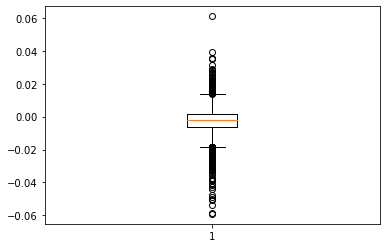

In [52]:
plt.boxplot(gdf_final['ratio_delta'])

In [53]:
#gdf_final.sort_values(by='ratio',ascending=False).head(10)

In [54]:
#(result.addr.str.contains('營盤里')&result.addr.str.contains('新莊區')).sum()

In [55]:
#gdf_final.sort_values(by=['ratio','戶口'],ascending=[True,False]).head(10)

In [56]:
#gdf_final['MarketPotential_normalization']=(gdf_final['MarketPotential']-gdf_final['MarketPotential'].min())/(gdf_final['MarketPotential'].max()-gdf_final['MarketPotential'].min())
#gdf_final['MarketPotential_density']=(gdf_final['MarketPotential'])/(gdf_final.to_crs({'init': 'epsg:3395'}).area/ 10**6)
#gdf_final['MarketPotential_density_normalization']=(gdf_final['MarketPotential_density']-gdf_final['MarketPotential_density'].min())/(gdf_final['MarketPotential_density'].max()-gdf_final['MarketPotential_density'].min())
#gdf_final['percent']=gdf_final['ratio'].map(lambda x:str(round(x*100,1))+'%')

In [57]:
#gdf_final['平均消費額_normalization']=(gdf_final['平均消費額2']-gdf_final['平均消費額2'].min())/(gdf_final['平均消費額2'].max()-gdf_final['平均消費額2'].min())

In [58]:
#gdf_final.loc[gdf_final['平均消費額_normalization'].isna(),['平均消費額_normalization']]=0

In [59]:
#gdf_final.head()

In [60]:
#gdf_final.to_excel(r'C:\Users\RT009223\TestriteGroup\滲透率專案\04_TLW\result\TLW_1G_2019台灣.xlsx',index=0)

# HOLA店點(部分) 

In [61]:
HOLA=pd.read_excel('HOLA店點.xlsx')
HOLA

,name,addr,type,lat,lon
0,北屯店,台中市北屯區北屯路407號,0,24.173757,120.697857
1,西屯店,台中市西屯區台灣大道四段528號,0,24.178658,120.624878
2,大墩店,台中市南屯區大墩路533號1F,0,24.149572,120.649650
3,彰化店,彰化縣和美鎮彰美路二段49號,0,24.092321,120.532854
4,Petite大魯閣新時代百貨,台中市東區復興路四段186號6樓,2,24.135776,120.687741
5,HOLA台北內湖店,台北市內湖區新湖三路23號,0,25.062268,121.574347
6,HOLA台北士林店,台北市士林區基河路258號地下1樓,0,25.092449,121.520136
7,Petite台北時代,台北市信義區忠孝東路五段8號6樓,1,25.040626,121.565461
8,HOLA台北中和店,新北市中和區中山路二段291號,0,25.001770,121.495829
9,HOLA台北土城店,新北市土城區青雲路152號三樓,0,24.983359,121.458923


# 畫圖

In [65]:
# 各車站定位
台北車站=[25.047741, 121.517384]
中壢車站=[24.953737, 121.225607]
台中車站=[24.137264, 120.686669]
嘉義車站=[23.479119, 120.441138]

#各縣市邊框顏色, '澎湖縣','金門縣','連江縣' '澎湖縣':'#00896C','金門縣':'#00896C','連江縣':'#00896C',
print(gdf_final['縣市'].unique())
site=['基隆市','新北市', '台北市','桃園市','新竹縣','新竹市','苗栗縣','台中市','彰化縣','南投縣',
      '雲林縣','嘉義縣','嘉義市','台南市',
      '高雄市','屏東縣','宜蘭縣','花蓮縣','台東縣']

site_colors={'基隆市':'#00896C','新北市':'#00896C', '台北市':'#00896C',
            '桃園市':'#465D4C','新竹縣':'#465D4C','新竹市':'#465D4C','苗栗縣':'#465D4C',
            '台中市':'#00896C','彰化縣':'#00896C','南投縣':'#00896C',
            '雲林縣':'#465D4C','嘉義縣':'#465D4C','嘉義市':'#465D4C','台南市':'#465D4C',
            '高雄市':'#00896C','屏東縣':'#00896C',
            '宜蘭縣':'#465D4C','花蓮縣':'#465D4C','台東縣':'#465D4C'}

#想畫顏色的變數
variable='ratio_delta2'

#設定色階
gdf_final['id']=gdf_final.index
color=gdf_final.set_index('id')[variable]

high=color.max()
low=color.min()
p=high/8
print(p)

#colorscale = branca.colormap.linear.RdBu_09.scale( low,high)
#colorscale.colors.reverse()
#branca.colormap.LinearColormap(colors=colorscale.colors,vmin=low,vmax=high)
#colorscale.to_step(index=[low, 0.09, high])
#colorscale
colorscale = branca.colormap.LinearColormap(colors=['blue','white','white','red'], index=[-0.05,-0.01,0.01,0.05],vmin=round(low,2),vmax=round(high,2))
colorscale


['高雄市' '屏東縣' '花蓮縣' '新竹市' '台東縣' '台中市' '嘉義縣' '桃園市' '南投縣' '雲林縣' '新竹縣' '嘉義市'
 '台南市' '基隆市' '苗栗縣' '宜蘭縣' '彰化縣' '新北市' '台北市']
0.007635180240320427


In [66]:
(round(high,2)-round(low,2))/8

0.015

In [67]:
colorscale(0.6)

'#ff0000ff'

In [68]:
color.isna().sum()

0

In [69]:
colorscale

In [70]:
# 顏色 style
def style_function(feature):
    colors = color.get(int(feature['id']), None)
    site_color=site_colors.get(feature['properties']['縣市'])
    return {
        'fillOpacity': 0.5,
        'weight': 1,
        'color':site_color,
        'fillColor': '#fff' if colors is None else colorscale(colors)
    }

In [71]:
# 設定圖例
#colormap=colorscale.to_step(index=[0, p*1, p*2, p*3, p*4,p*5,p*6,p*7,p*8])
#colormap=colorscale.to_step(index=[-0.1,-0.075,-0.05,-0.025,0,0.025,0.05,0.075,0.1])
colormap=colorscale
colormap.caption ='Member Penetration Rates(Delta)'
#colormap.caption ='Average Consumption'

In [72]:
mm=folium.Map(location=台北車站,zoom_start=14)
for s in site:
    folium.GeoJson(
        gdf_final[gdf_final['縣市']==s][['geometry','縣市','行政區','村里','戶口','人口','會員數','ratio','percent','ratio_delta','ratio_delta2','percent_delta','會員數_delta_rate','戶口_delta_rate','戶口_delta_percent']],
        name=s, 
        style_function=style_function,
        highlight_function=lambda x: {'weight':3, 
                                        'color':site_colors.get(x['properties']['縣市']),
                                        'fillOpacity':0.75},
        smooth_factor=2.0,
        tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','戶口','戶口_delta_percent','percent','percent_delta',],
                                                  aliases=['縣市','行政區','村里','戶數','戶數變動','滲透率','滲透率變動'], 
                                                  labels=True, 
                                                  sticky=True,
                                                  toLocaleString=True
                                                 )
    ).add_to(mm)

for i in range(HOLA.shape[0]):
    if HOLA.type[i]==0:
        iframe = IFrame(html=heading3(utf2asc(HOLA.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[HOLA.lat[i], HOLA.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='lightblue')).add_to(mm)
    elif HOLA.type[i]==2:
        iframe = IFrame(html=heading3(utf2asc(HOLA.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[HOLA.lat[i], HOLA.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='beige')).add_to(mm)
    else:  
        iframe = IFrame(html=heading3(utf2asc(HOLA.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[HOLA.lat[i], HOLA.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='gray')).add_to(mm)    

colormap.add_to(mm)

folium.LayerControl().add_to(mm)


In [132]:
#mm

In [73]:
mm.save(r'C:\Users\RT009223\TestriteGroup\滲透率專案\05_HOLA\result\台灣2020H1年HOLA(含Petite)滲透率(Delta)B.html')